This document is number `5 of 5` documents I have written, based on the `LangChain Academy Deep Agents with LangGraph` course.

The course itself has repositories that it provides you with. If my documents are not useful to you, I suggest you check them out.

There are now several successful examples of very **capable** and **long-running** agents. They have given these agents the 
name `“Deep Agents”` because they believe that they are completely different from previous generations of agents. In 
this course, you will learn what makes them different and build your own Deep Agent.

In LangChain, a Deep Agent is built that is simple and configurable, allowing users to build long-running agents quickly and easily.

In this course, you will build a **Deep Research Agent** using Deep Agent. The course is divided into seven modules.

Each module includes a video lesson that introduces you to the key concepts, along with related workbooks.

***

## Deep Agent for Research

### Now, we can put everything we have learned together:

- We will use `TODOs` to keep track of tasks.
- We will use `files` to store raw tool call results.
- We will delegate research tasks to `sub-agents` for context isolation.

#### Search Tool
We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, as we've seen with Manus!

#### Core Components
1. **Search Execution (run_tavily_search):** Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (summarize_webpage_content):** Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (process_search_results):** Fetches full webpage content via HTTP, converts HTML to markdown using markdownify, and generates summaries for each result.

4. **Context Offloading (tavily_search tool):** The main tool that:
- Executes search and processes results
- Saves full content to files in agent state (context offloading)
- Returns only minimal summaries to the agent (prevents context spam)
- Uses LangGraph Command to update both files and messages

5. **Strategic Thinking (think_tool):** Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

### Imports

In [1]:
import os
from datetime import datetime
import uuid, base64

import httpx
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt.chat_agent_executor import AgentState, BaseTool
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal, NotRequired, TypedDict


### Reducer Function

In [2]:
def file_reducer(left, right):
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}

### Data Models and Type Definitions

In [3]:
class Todo(TypedDict):
    content: str
    status: Literal["pending", "in_progress", "completed"]

class SubAgent(TypedDict):
    name: str                       
    description: str                
    prompt: str                     
    tools: NotRequired[list[str]]   

class DeepAgentState(AgentState):
    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

### Planning: TODO Lists

#### Tool Description - Todo Tool

In [4]:
WRITE_TODOS_DESCRIPTION= """ 
| Create and manage structured task lists for tracking progress through complex workflows.                        │
│                                                                                                                 │
│  ## When to Use                                                                                                 │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions                                                                            │
│                                                                                                                 │
│  ## Structure                                                                                                   │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│                                                                                                                 │
│  ## Best Practices                                                                                              │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│                                                                                                                 │
│  ## Progress Updates                                                                                            │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│                                                                                                                 │
│  ## Parameters                                                                                                  │
│  - todos: List of TODO items with content and status fields                                                     │
│                                                                                                                 │
│  ## Returns                                                                                                     │
│  Updates agent state with new todo list. """

#### Write and Read ToDo Tools

In [5]:
@tool(description=WRITE_TODOS_DESCRIPTION ,parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get("todos", [])
    if not todos:
        return "No todos currently in the list."

    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"
    return result.strip()

c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


#### Todo Usage Instructions

In [6]:
TODO_USAGE_INSTRUCTIONS= """
| Based upon the user's request:                                                                                  │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. **CRITICAL: When completing a research/summary task, you MUST provide the actual content requested**        │
│     - Do NOT just mark the task as completed                                                                    │
│     - Use the search results to create a comprehensive summary/answer                                           │
│     - Provide the actual information the user asked for                                                         │
│  5. Mark your task as completed ONLY AFTER providing the requested content                                      │
│  6. Continue this process until you have completed all TODOs AND provided all requested content                 │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│  IMPORTANT: **NEVER mark a research task as completed without providing the actual research results/summary**   │
IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question.
CRITICAL: You must provide a comprehensive summary/answer based on the search results. Do not just acknowledge that you found information - actually provide the information the user requested."""

### Context Offloading: Filesystem

The descriptions in the prompts below describe in detail how they operate:
- LS
- Read
- Write

In [7]:
LS_DESCRIPTION= """
| List all files in the virtual filesystem stored in agent state.                                                 │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          |
"""

READ_FILE_DESCRIPTION= """
|  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        | 
"""


WRITE_FILE_DESCRIPTION= """ 
|  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content. Use edit_file for partial modifications.                     |
"""

#### File Tools

In [8]:
@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())

@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    # Include line numbers, truncate very long lines
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)

@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object 

#### File Usage Instructions

In [9]:
FILE_USAGE_INSTRUCTIONS = """You MUST follow this exact workflow for every user request:

1. **ALWAYS start by calling ls()** to check existing files
2. **ALWAYS call write_file()** to save the user's request to "user_request.txt" 
3. **THEN call web_search()** exactly once to gather information
4. **ALWAYS call read_file()** to re-read the saved user request
5. **ONLY THEN provide your final answer** based on the research and saved request

DO NOT skip any steps. DO NOT take shortcuts. This workflow is mandatory.


SIMPLE_RESEARCH_INSTRUCTIONS: After completing the required file workflow above, use web_search exactly once and base your answer on both the search results and the saved user request.

CRITICAL: You will be marked as FAILED if you:
- Skip calling ls() first
- Skip saving the user request with write_file()  
- Skip reading back the request with read_file()
- Use web_search without following the file workflow
"""

### Context Isolation: Sub-agents

In [10]:
TASK_DESCRIPTION_PREFIX = """Delegate a task to a specialized sub-agent with isolated context.

This tool allows you to delegate specific tasks to specialized sub-agents that run in clean, isolated contexts. Each sub-agent is designed for a specific type of work and has access to only the tools it needs.

Available sub-agents:
{other_agents}

Use this tool when you need to delegate work that requires specialized knowledge or tools. The sub-agent will work in isolation and return its results to you."""

#### Create a tool to use Sub Agents

In [11]:
def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    # Create agent registry
    agents = {}

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Create specialized sub-agents based on configurations
    for _agent in subagents:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools
        agents[_agent["name"]] = create_react_agent(
            model, prompt=_agent["system_prompt"], tools=_tools, state_schema=state_schema
        )

    # Generate description of available sub-agents for the tool description
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

#### SubAgent Usage Instructions

In [12]:
SUBAGENT_USAGE_INSTRUCTIONS =""" You can delegate tasks to sub-agents.                                            │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element of the comparison:                                        │
│  - *Example*: "Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety" → Use 3 sub-agents            │
│  - Store findings in separate files: `findings_openai_safety.md`, `findings_anthropic_safety.md`,               │
│  `findings_deepmind_safety.md`                                                                                  │
│                                                                                                                 │
│  **Multi-faceted research** can use parallel agents for different aspects:                                      │
│  - *Example*: "Research renewable energy: costs, environmental impact, and adoption rates" → Use 3 sub-agents   │
│  - Organize findings by aspect in separate files                                                                │
│                                                                                                                 │
│  **Important Reminders:**                                                                                       │
│  - Each **task** call creates a dedicated research agent with isolated context                                  │
│  - Sub-agents can't see each other's work - provide complete standalone instructions                            │
│  - Use clear, specific language - avoid acronyms or abbreviations in task descriptions                          │
│  </Scaling Rules>                                                                                               | 

SIMPLE_RESEARCH_INSTRUCTIONS: You are a researcher. Research the topic provided to you. 

IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic.

Your response should be:
1. Concise and focused on the specific topic
2. Based only on the web search results provided
3. Well-structured and informative
4. No more than 2-3 paragraphs"""

### Geting current date

In [13]:
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    now = datetime.now()
    # Use cross-platform compatible format (remove leading zero from day)
    day = now.day
    return now.strftime(f"%a %b {day}, %Y")

### Preparing a summary model

In [ ]:
# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini", api_key= "sk-proj-***")
tavily_client = TavilyClient(api_key="tvly-dev-***")

### The Tavilly function 
takes parameters and returns one search result.

In [15]:
def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

### Summarizing the content of the Tavily search

In [16]:


SUMMARIZE_WEB_SEARCH = """
You are an expert research assistant, and your task is to produce a concise, accurate summary of the following web page content for a user conducting research on a particular date.

Guidelines:
- Focus on the main points, key findings, and important context.
- Be clear, factual, and neutral. Do not add opinion or fabrication.
- If the text is very long, prioritize what is most relevant and ignore repetition or low-value content.
- Respond in 2-3 informative paragraphs summarizing the essence of the page.
- Do not include advertisements, navigation menus, copyright text, or unrelated links.
- End with a very brief description of the page's purpose or topic, if clear.

Today's date: {date}

Content to summarize:
"{webpage_content}"

Your summary:
"""

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )


### Fielding the content of search results

In [17]:

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results


### Preparing the final text using fields prepared from the search

In [18]:
@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


### Think Tool: To guide the model in choosing the right path

In [19]:
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

### Research Instructions for SubAgent

In [20]:
RESEARCHER_INSTRUCTIONS ="""You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                                                                                 │
│  **Stop Immediately When**:                                                                                     │
│  - You can answer the user's question comprehensively                                                           │
│  - You have 3+ relevant examples/sources for the question                                                       │
│  - Your last 2 searches returned similar information                                                            │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Show Your Thinking>                                                                                           │
│  After each search tool call, use think_tool to analyze the results:                                            │
│  - What key information did I find?                                                                             │
│  - What's missing?                                                                                              │
│  - Do I have enough to answer the question comprehensively?                                                     │
│  - Should I search more or provide my answer?                                                                   │
│  </Show Your Thinking>                                                                                          │
"""

## Deep Agent
Now, we can just apply all of our prior learnings:

- We'll give the researcher a `think_tool` and our `search_tool` above.
- We'll give our parent agent file tools, a `think_tool`, and a `task` tool.

In [ ]:
# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-4o-mini", api_key= "sk-proj-***", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=get_today_str(),
)

C:\Users\PN\AppData\Local\Temp\ipykernel_15616\832146826.py:34: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agents[_agent["name"]] = create_react_agent(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an 

### All Instructions

In [22]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_USAGE_INSTRUCTIONS
)

### Creating and Drawing the Agent

C:\Users\PN\AppData\Local\Temp\ipykernel_15616\3548560376.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


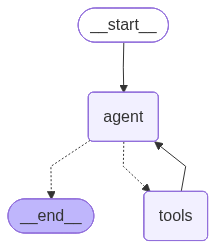

In [23]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png())) 

### Invoke the Agent

In [24]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

result["messages"] 

[HumanMessage(content='Give me an overview of Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='8fd85ae0-411c-43bc-9cdb-11677639f180'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HLga6OJnr9EClSZGNeiufOsY', 'function': {'arguments': '{}', 'name': 'ls'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 2791, 'total_tokens': 2801, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CWKteKd92JyW8jmaHhzBZlbj8VclP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--8d761e87-cbff-406b-9a2a-2ef1cf5e6214-0', tool_calls=[{'name': 'ls', 'args': {}, 'id': 'call_HLga6OJnr9EClSZGNeiufOsY', 'typ

### Pretty Print Function
To better understand what the agent does and also see the workflow 

#### Func 1:

In [25]:
def pretty_print_conversation(messages):
    """
    Pretty print a conversation from an agent's message history.
    
    Args:
        messages: List of message objects from agent.invoke() result
    """
    print("=" * 80)
    print("🤖 AGENT CONVERSATION LOG")
    print("=" * 80)
    
    for i, message in enumerate(messages, 1):
        print(f"\n📝 Message #{i}")
        print("-" * 40)
        
        # Get message type
        msg_type = type(message).__name__
        print(f"Type: {msg_type}")
        
        # Get role if available
        if hasattr(message, 'role'):
            print(f"Role: {message.role}")
        
        # Get content
        if hasattr(message, 'content') and message.content:
            content = message.content
            if isinstance(content, str):
                print(f"Content: {content}")
            elif isinstance(content, list):
                print("Content: [List of items]")
                for j, item in enumerate(content):
                    print(f"  {j+1}. {item}")
            else:
                print(f"Content: {content}")
        
        # Get tool calls if available
        if hasattr(message, 'tool_calls') and message.tool_calls:
            print(f"Tool Calls: {len(message.tool_calls)}")
            for j, tool_call in enumerate(message.tool_calls):
                print(f"  {j+1}. {tool_call.get('name', 'Unknown')} - {tool_call.get('id', 'No ID')}")
                if 'function' in tool_call and 'arguments' in tool_call['function']:
                    args = tool_call['function']['arguments']
                    print(f"     Arguments: {args}")
        
        # Get additional kwargs if available
        if hasattr(message, 'additional_kwargs') and message.additional_kwargs:
            print(f"Additional Info: {message.additional_kwargs}")
        
        # Get response metadata if available
        if hasattr(message, 'response_metadata') and message.response_metadata:
            metadata = message.response_metadata
            if 'token_usage' in metadata:
                tokens = metadata['token_usage']
                print(f"Token Usage: {tokens.get('total_tokens', 'N/A')} total")
                print(f"  - Input: {tokens.get('prompt_tokens', 'N/A')}")
                print(f"  - Output: {tokens.get('completion_tokens', 'N/A')}")
        
        print()
    
    print("=" * 80)
    print("✅ CONVERSATION COMPLETE")
    print("=" * 80)

pretty_print_conversation(result["messages"])

🤖 AGENT CONVERSATION LOG

📝 Message #1
----------------------------------------
Type: HumanMessage
Content: Give me an overview of Model Context Protocol (MCP).


📝 Message #2
----------------------------------------
Type: AIMessage
Tool Calls: 1
  1. ls - call_HLga6OJnr9EClSZGNeiufOsY
Additional Info: {'tool_calls': [{'id': 'call_HLga6OJnr9EClSZGNeiufOsY', 'function': {'arguments': '{}', 'name': 'ls'}, 'type': 'function'}], 'refusal': None}
Token Usage: 2801 total
  - Input: 2791
  - Output: 10


📝 Message #3
----------------------------------------
Type: ToolMessage


📝 Message #4
----------------------------------------
Type: AIMessage
Tool Calls: 1
  1. write_file - call_8WNDnszPKYJnG6Yv0b1hCP8p
Additional Info: {'tool_calls': [{'id': 'call_8WNDnszPKYJnG6Yv0b1hCP8p', 'function': {'arguments': '{"file_path":"user_request.txt","content":"Give me an overview of Model Context Protocol (MCP)."}', 'name': 'write_file'}, 'type': 'function'}], 'refusal': None}
Token Usage: 2840 total
  - I

#### Func 2:

In [26]:
def pretty_print_conversation(messages):
    """
    Pretty print a conversation from LangChain messages with enhanced formatting.
    
    Args:
        messages: List of LangChain message objects (HumanMessage, AIMessage, ToolMessage)
    """
    print("=" * 80)
    print("🤖 CONVERSATION TRACE")
    print("=" * 80)
    
    for i, message in enumerate(messages, 1):
        message_type = type(message).__name__
        
        # Human Message
        if message_type == "HumanMessage":
            print(f"\n👤 **HUMAN** (Message #{i})")
            print("-" * 40)
            print(f"📝 {message.content}")
            
        # AI Message  
        elif message_type == "AIMessage":
            print(f"\n🤖 **ASSISTANT** (Message #{i})")
            print("-" * 40)
            
            # Check if there's text content
            if message.content:
                print(f"💬 **Response:**")
                print(f"   {message.content}")
            
            # Check for tool calls
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"🔧 **Tool Calls:**")
                for j, tool_call in enumerate(message.tool_calls, 1):
                    print(f"   {j}. **{tool_call['name']}**")
                    if tool_call['args']:
                        print(f"      Args: {tool_call['args']}")
                    else:
                        print(f"      Args: (none)")
            
            # Token usage info
            if hasattr(message, 'usage_metadata') and message.usage_metadata:
                usage = message.usage_metadata
                print(f"📊 **Tokens:** Input: {usage.get('input_tokens', 'N/A')} | Output: {usage.get('output_tokens', 'N/A')} | Total: {usage.get('total_tokens', 'N/A')}")
        
        # Tool Message
        elif message_type == "ToolMessage":
            print(f"\n⚙️ **TOOL RESULT** (Message #{i})")
            print("-" * 40)
            print(f"🔧 **Tool:** {message.name}")
            
            # Check for errors
            if hasattr(message, 'status') and message.status == 'error':
                print(f"❌ **Status:** ERROR")
                print(f"💥 **Error:** {message.content}")
            else:
                print(f"✅ **Status:** SUCCESS")
                
                # Format content based on length and type
                content = str(message.content)
                if len(content) > 200:
                    print(f"📄 **Result:** {content[:200]}...")
                    print(f"   📏 Full length: {len(content)} characters")
                elif len(content) == 0 or content == "[]":
                    print(f"📄 **Result:** (empty)")
                else:
                    print(f"📄 **Result:** {content}")
        
        # Unknown message type
        else:
            print(f"\n❓ **UNKNOWN MESSAGE TYPE: {message_type}** (Message #{i})")
            print("-" * 40)
            print(f"📄 Content: {getattr(message, 'content', 'No content')}")

    print("\n" + "=" * 80)
    print("✅ END OF CONVERSATION")
    print("=" * 80)

# Usage example:
pretty_print_conversation(result["messages"])

🤖 CONVERSATION TRACE

👤 **HUMAN** (Message #1)
----------------------------------------
📝 Give me an overview of Model Context Protocol (MCP).

🤖 **ASSISTANT** (Message #2)
----------------------------------------
🔧 **Tool Calls:**
   1. **ls**
      Args: (none)
📊 **Tokens:** Input: 2791 | Output: 10 | Total: 2801

⚙️ **TOOL RESULT** (Message #3)
----------------------------------------
🔧 **Tool:** ls
✅ **Status:** SUCCESS
📄 **Result:** (empty)

🤖 **ASSISTANT** (Message #4)
----------------------------------------
🔧 **Tool Calls:**
   1. **write_file**
      Args: {'file_path': 'user_request.txt', 'content': 'Give me an overview of Model Context Protocol (MCP).'}
📊 **Tokens:** Input: 2808 | Output: 32 | Total: 2840

⚙️ **TOOL RESULT** (Message #5)
----------------------------------------
🔧 **Tool:** write_file
✅ **Status:** SUCCESS
📄 **Result:** Updated file user_request.txt

🤖 **ASSISTANT** (Message #6)
----------------------------------------
🔧 **Tool Calls:**
   1. **tavily_search*

## Using the Deep Agent Package
**Now you understand the underlying patterns!**

You can use the deepagents package as a simple abstraction:

- It include the file system tools
- It includes the todo tool
- It includes the task tool

You only need to supply the **sub-agent** and any **tools** you want the sub-agent to use.

In [27]:
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": [tavily_search, think_tool],
}

---

## **Notice**
### Why did I bring up research_sub_agent again?


**Bug:** `Documentation shows incorrect tool configuration format for subagents while use deepagents package`

### Issue Description:

#### Description
The documentation contains incorrect code examples for configuring subagent tools. The example shows tool names as `strings` instead of actual tool `objects`, which causes a runtime error.

#### Current Code
```python
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],  # ❌ WRONG: strings instead of objects
}
```

#### Expected Code
```python
research_sub_agent = {
    "name": "research-agent", 
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": [tavily_search, think_tool],  # ✅ CORRECT: actual tool objects
}
```

### Error Caused
When using the documented approach, users get:

`AttributeError: 'function' object has no attribute 'name'`


### Additional Context
The `tools` field expects actual tool objects (decorated with `@tool`), not string references to tool names. LangChain's `_ToolNode` requires tool objects with a `.name` attribute.

---

c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object 

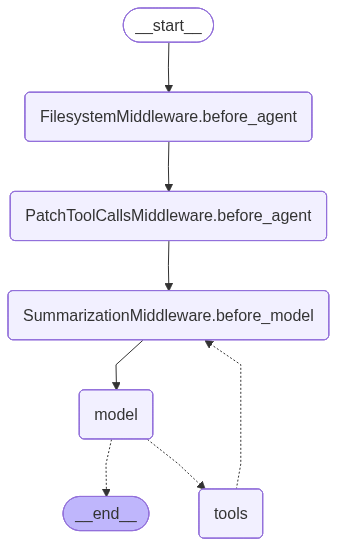

In [28]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    model =model,  
    system_prompt=INSTRUCTIONS,
    tools=sub_agent_tools,  
    subagents=[research_sub_agent]
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [32]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

result["messages"]

[HumanMessage(content='Give me an very brief overview of Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='f6a1243e-f471-4d28-94df-4eb84068e8f7'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6zE65Pgp54WzFyZGvKwgyvBq', 'function': {'arguments': '{}', 'name': 'ls'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 5644, 'total_tokens': 5654, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 5504}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CWL1AXoDw1lsCY43js1ud3JKlBZ0W', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--c9235970-46f9-4b4d-9c19-d6d3c4f6f106-0', tool_calls=[{'name': 'ls', 'args': {}, 'id': 'call_6zE65Pgp54WzFyZGv

### Pretty Print Function
To better understand what the agent does and also see the workflow 

#### Func 1:

In [33]:
def pretty_print_conversation(messages):
    """
    Pretty print a conversation from an agent's message history.
    
    Args:
        messages: List of message objects from agent.invoke() result
    """
    print("=" * 80)
    print("🤖 AGENT CONVERSATION LOG")
    print("=" * 80)
    
    for i, message in enumerate(messages, 1):
        print(f"\n📝 Message #{i}")
        print("-" * 40)
        
        # Get message type
        msg_type = type(message).__name__
        print(f"Type: {msg_type}")
        
        # Get role if available
        if hasattr(message, 'role'):
            print(f"Role: {message.role}")
        
        # Get content
        if hasattr(message, 'content') and message.content:
            content = message.content
            if isinstance(content, str):
                print(f"Content: {content}")
            elif isinstance(content, list):
                print("Content: [List of items]")
                for j, item in enumerate(content):
                    print(f"  {j+1}. {item}")
            else:
                print(f"Content: {content}")
        
        # Get tool calls if available
        if hasattr(message, 'tool_calls') and message.tool_calls:
            print(f"Tool Calls: {len(message.tool_calls)}")
            for j, tool_call in enumerate(message.tool_calls):
                print(f"  {j+1}. {tool_call.get('name', 'Unknown')} - {tool_call.get('id', 'No ID')}")
                if 'function' in tool_call and 'arguments' in tool_call['function']:
                    args = tool_call['function']['arguments']
                    print(f"     Arguments: {args}")
        
        # Get additional kwargs if available
        if hasattr(message, 'additional_kwargs') and message.additional_kwargs:
            print(f"Additional Info: {message.additional_kwargs}")
        
        # Get response metadata if available
        if hasattr(message, 'response_metadata') and message.response_metadata:
            metadata = message.response_metadata
            if 'token_usage' in metadata:
                tokens = metadata['token_usage']
                print(f"Token Usage: {tokens.get('total_tokens', 'N/A')} total")
                print(f"  - Input: {tokens.get('prompt_tokens', 'N/A')}")
                print(f"  - Output: {tokens.get('completion_tokens', 'N/A')}")
        
        print()
    
    print("=" * 80)
    print("✅ CONVERSATION COMPLETE")
    print("=" * 80)

pretty_print_conversation(result["messages"])


🤖 AGENT CONVERSATION LOG

📝 Message #1
----------------------------------------
Type: HumanMessage
Content: Give me an very brief overview of Model Context Protocol (MCP).


📝 Message #2
----------------------------------------
Type: AIMessage
Tool Calls: 1
  1. ls - call_6zE65Pgp54WzFyZGvKwgyvBq
Additional Info: {'tool_calls': [{'id': 'call_6zE65Pgp54WzFyZGvKwgyvBq', 'function': {'arguments': '{}', 'name': 'ls'}, 'type': 'function'}], 'refusal': None}
Token Usage: 5654 total
  - Input: 5644
  - Output: 10


📝 Message #3
----------------------------------------
Type: ToolMessage


📝 Message #4
----------------------------------------
Type: AIMessage
Tool Calls: 1
  1. write_file - call_muU6zcvnJhFlK4o9sUX9oc8K
Additional Info: {'tool_calls': [{'id': 'call_muU6zcvnJhFlK4o9sUX9oc8K', 'function': {'arguments': '{"file_path":"/user_request.txt","content":"Give an overview of Model Context Protocol (MCP)."}', 'name': 'write_file'}, 'type': 'function'}], 'refusal': None}
Token Usage: 5693 to

#### Func 2:

In [34]:
def pretty_print_conversation(messages):
    """
    Pretty print a conversation from LangChain messages with enhanced formatting.
    
    Args:
        messages: List of LangChain message objects (HumanMessage, AIMessage, ToolMessage)
    """
    print("=" * 80)
    print("🤖 CONVERSATION TRACE")
    print("=" * 80)
    
    for i, message in enumerate(messages, 1):
        message_type = type(message).__name__
        
        # Human Message
        if message_type == "HumanMessage":
            print(f"\n👤 **HUMAN** (Message #{i})")
            print("-" * 40)
            print(f"📝 {message.content}")
            
        # AI Message  
        elif message_type == "AIMessage":
            print(f"\n🤖 **ASSISTANT** (Message #{i})")
            print("-" * 40)
            
            # Check if there's text content
            if message.content:
                print(f"💬 **Response:**")
                print(f"   {message.content}")
            
            # Check for tool calls
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"🔧 **Tool Calls:**")
                for j, tool_call in enumerate(message.tool_calls, 1):
                    print(f"   {j}. **{tool_call['name']}**")
                    if tool_call['args']:
                        print(f"      Args: {tool_call['args']}")
                    else:
                        print(f"      Args: (none)")
            
            # Token usage info
            if hasattr(message, 'usage_metadata') and message.usage_metadata:
                usage = message.usage_metadata
                print(f"📊 **Tokens:** Input: {usage.get('input_tokens', 'N/A')} | Output: {usage.get('output_tokens', 'N/A')} | Total: {usage.get('total_tokens', 'N/A')}")
        
        # Tool Message
        elif message_type == "ToolMessage":
            print(f"\n⚙️ **TOOL RESULT** (Message #{i})")
            print("-" * 40)
            print(f"🔧 **Tool:** {message.name}")
            
            # Check for errors
            if hasattr(message, 'status') and message.status == 'error':
                print(f"❌ **Status:** ERROR")
                print(f"💥 **Error:** {message.content}")
            else:
                print(f"✅ **Status:** SUCCESS")
                
                # Format content based on length and type
                content = str(message.content)
                if len(content) > 200:
                    print(f"📄 **Result:** {content[:200]}...")
                    print(f"   📏 Full length: {len(content)} characters")
                elif len(content) == 0 or content == "[]":
                    print(f"📄 **Result:** (empty)")
                else:
                    print(f"📄 **Result:** {content}")
        
        # Unknown message type
        else:
            print(f"\n❓ **UNKNOWN MESSAGE TYPE: {message_type}** (Message #{i})")
            print("-" * 40)
            print(f"📄 Content: {getattr(message, 'content', 'No content')}")

    print("\n" + "=" * 80)
    print("✅ END OF CONVERSATION")
    print("=" * 80)

# Usage example:
pretty_print_conversation(result["messages"])

🤖 CONVERSATION TRACE

👤 **HUMAN** (Message #1)
----------------------------------------
📝 Give me an very brief overview of Model Context Protocol (MCP).

🤖 **ASSISTANT** (Message #2)
----------------------------------------
🔧 **Tool Calls:**
   1. **ls**
      Args: (none)
📊 **Tokens:** Input: 5644 | Output: 10 | Total: 5654

⚙️ **TOOL RESULT** (Message #3)
----------------------------------------
🔧 **Tool:** ls
✅ **Status:** SUCCESS
📄 **Result:** (empty)

🤖 **ASSISTANT** (Message #4)
----------------------------------------
🔧 **Tool Calls:**
   1. **write_file**
      Args: {'file_path': '/user_request.txt', 'content': 'Give an overview of Model Context Protocol (MCP).'}
📊 **Tokens:** Input: 5661 | Output: 32 | Total: 5693

⚙️ **TOOL RESULT** (Message #5)
----------------------------------------
🔧 **Tool:** write_file
✅ **Status:** SUCCESS
📄 **Result:** Updated file /user_request.txt

🤖 **ASSISTANT** (Message #6)
----------------------------------------
🔧 **Tool Calls:**
   1. **tavi